# Theorist Tutorial

[Theorists](../../theorist) are classes designed to automate the construction of interpretable models from data. AutoRA theorists are implemented as sklearn regressors and can be used with the `fit` and `predict` methods.

![Theorist](attachment:theorist.png)

In order to use a theorist, you must first install the corresponding theorist package. Some theorists are installed by default when you install ``autora``. Once a theorist is installed, you can instantiate it and use it as you would any other sklearn regressor. That is, you can call the ``fit`` function of the theorist by passing in experimental conditions and corresponding observations, and then call the ``predict`` function to generate predicted observations for novel experimental conditions using the discovered model.

The following tutorial demonstrates how to use the `BMSRegressor` (Guimerà et al., 2020, in Sci. Adv.)–a theorist that can discover an interpretable equation relating the independent variables of an experiment (experiment conditions) to predicted dependent variables (observations).

In this tutorial, we will follow the 6 step workflow for model recovery:
1. Install packages
2. Import packages
3. Load Data (or generate synthetic data)
4. Initialize Regressor
5. Fit Regressor
6. Evaluate Regressor (Present Results)

## Section A: Simple Model Recovery

###1. Install Packages

In [ ]:
# Uncomment the following line when running on Google Colab
!pip install "autora[theorist-bms]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.1 MB/s eta 0:00:00


###2. Import packages



In [ ]:
from autora.theorist.bms import BMSRegressor
import numpy as np
import matplotlib.pyplot as plt

###3. Load data (or generate synthetic data)

We generate synthetic ground-truth data corresponding to the equation, $y = \sin(x) + x^3$.

In [ ]:
x = np.expand_dims(np.linspace(start=-1, stop=1, num=500), 1)
y = np.power(x, 3) + np.sin(x)

###4. Initialize Regressor

We set up the BMS regressor with our chosen meta parameters. In this case, we will specify the number of `epochs` as well as temperatures (`ts`). Note, BMS also allows users to specify unique priors over the operations considered in the search space (`prior_par`), but in this simple example we will stick with those priors implemented by the original authors, Guimerà et al. (2020). The temperatures argument is also optional.


In [ ]:
temperatures = [1.0] + [1.04**k for k in range(1, 20)]

bms_estimator = BMSRegressor(
    epochs=500,
    ts=temperatures,
)

###5. Fit Regressor

With our regressor initialized, we can call the `fit` method to discover an equation for our data and then use the `predict` method to generate predictions using our discovered equation.

In [ ]:
bms_estimator.fit(x,y)
y_pred = bms_estimator.predict(x)

100%|██████████| 500/500 [01:29<00:00,  5.61it/s]


###6. Evaluate Regressor

Finally, we can plot the results.

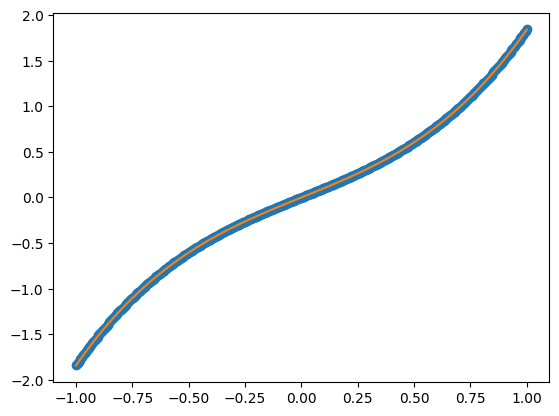

(sin(X0) + (X0 ** 3))


In [ ]:
# plot out the ground truth versus predicted responses
plt.figure()
plt.plot(x, y, "o")
plt.plot(x, y_pred, "-")
plt.show()
print(bms_estimator.model_)

In this simple case, the algorithm finds an equation with a perfect fit.


## Section B: Continuous Model Recovery

In this section, we will compare model recovery between 3 regressor models. Two will be chosen from or built using sci-kit learn. The final one will be the Bayesian Machine Scientist

###1. Install Packages

In [ ]:
# Uncomment the following line when running on Google Colab
# !pip install "autora[theorist-bms]"

###2. Import packages

In [ ]:
from autora.theorist.bms import BMSRegressor
from autora.experiment_runner.synthetic.psychophysics.weber_fechner_law import weber_fechner_law
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch

###3. Load data (or generate synthetic data)

We generate synthetic data from AutoRA's inventory of synthetic models

Here, we generate a synthetic example of Weber-Fechner's Law:
$p=k*ln(S/S_0)$, with $k=3.0$

In [ ]:
# experimental parameter to recover
constant = 3.0

# synthetic experiment from autora inventory
synthetic_data = weber_fechner_law(constant=constant, added_noise=0.01)

# experimental data
conditions = synthetic_data.domain()
observations = synthetic_data.experiment_runner(conditions)

# split into train and test datasets
conditions_train, conditions_test, observations_train, observations_test = train_test_split(conditions, observations)

###Model Recovery

We will use three models:
1. Polynomial Regressor
2. Neural Network
3. Bayesian Machine Scientist

####Plot functions
*You can skip over these cells*

In [ ]:
def compare_results(models, x_test, y_test, arg='default', model_names=None, variable_names=None, observation_name=None, select_indices=None, figsize=None, *args):
  if model_names is None or model_names == [None]:
    names = ['Model '+str(i+1) for i in range(len(models))]
  else:
    names = model_names
  if len(x_test.shape) == 1:
    x_test = x_test.reshape(1, -1)
  num_var = x_test.shape[1]
  if variable_names is None:
    var_names = ['Variable '+str(i+1) for i in range(num_var)]
  else:
    var_names = variable_names
  if observation_name is None:
    obs_label = 'Observations'
  else:
    obs_label = observation_name
  match arg:
    case 'default':
      for i, model in enumerate(models):
        print(model)
        synthetic_data.plotter(model)
    case '2d':
      if figsize is None:
        size = (8,3)
      else:
        assert len(figsize) == 2 and isinstance(figsize, tuple), 'incorrect format for figure shape\nshould be tuple of form (i,j)'
        size = figsize
      for i, model in enumerate(models):
        fig = plt.figure(figsize=size)
        axes = []
        y_predict = model.predict(x_test)
        for j in range(num_var):
          axes.append(fig.add_subplot(1, num_var, j+1))
          axes[j].set_xlabel(var_names[j])
          axes[j].set_ylabel(obs_label)
          axes[j].set_title(names[i]+' fit on '+var_names[j])
          axes[j].scatter(x_test[:,j], y_test, label='Ground Truth', alpha=0.5)
          axes[j].scatter(x_test[:,j], y_predict, label='Predicted', alpha=0.5)
          axes[j].legend()
          for arg in args:
            assert isinstance(arg, str), 'arguments must be in the form of a string'
            try:
              exec('axes[j].'+arg)
            except:
              raise RuntimeError(f'argument "{arg}" could not be executed')

      fig.tight_layout()
      plt.show()
    case '3d':
      if figsize is None:
        size = (15,5)
      else:
        assert len(figsize) == 2 and isinstance(figsize, tuple), 'incorrect format for figure shape\nshould be tuple of form (i,j)'
        size = figsize
      axes = []
      fig = plt.figure(figsize=size)
      if select_indices is None:
        idx = (0,1)
      else:
        len(select_indices) == 2 and isinstance(select_indices, tuple), 'incorrect format for select_indices\nshould be tuple of form (i,j)'
        idx = select_indices
      for i, model in enumerate(models):
        y_predict = model.predict(x_test)
        ax = fig.add_subplot(1, 3, i+1, projection='3d')
        ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        axes.append(ax)
        axes[i].set_xlabel(var_names[idx[0]])
        axes[i].set_ylabel(var_names[idx[1]])
        axes[i].set_zlabel(obs_label)
        axes[i].scatter(x_test[:, idx[0]], x_test[:, idx[1]], y_test, s=1, label='Ground Truth')
        axes[i].scatter(x_test[:, idx[0]], x_test[:, idx[1]], y_predict, s=1, label='Predicted')
        axes[i].set_title(names[i])
        axes[i].legend()
        axes[i].set_facecolor('white')
        for arg in args:
            assert isinstance(arg, str), 'arguments must be in the form of a string'
            try:
              exec('axes[j].'+arg)
            except:
              raise RuntimeError(f'argument "{arg}" could not be executed')
      fig.tight_layout()
      plt.show()
    case 'choice':
      for model in models:
        y_pred = np.where(model.predict(x_test) > 0.5, 1, 0)
        cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
        cmd = ConfusionMatrixDisplay(cm)
        cmd.plot()
        plt.show()

In [ ]:
def present_results(model, x_test, y_test, arg='default', model_name=None, variable_names=None, select_indices=None, figsize=None, *args):
  compare_results(models=[model], x_test=x_test, y_test=y_test, arg=arg, model_names=[model_name], variable_names=variable_names, select_indices=select_indices, figsize=figsize, *args)

###Polynomial Regressor

We create a regressor model using functions provided by the sci-kit learn package

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


class PolynomialRegressor:
    """
    This theorist fits a polynomial function to the data.
    """

    def __init__(self, degree: int = 3):
      self.poly = PolynomialFeatures(degree=degree, include_bias=False)
      self.model = LinearRegression()

    def fit(self, x, y):
      features = self.poly.fit_transform(x, y)
      self.model.fit(features, y)
      return self

    def predict(self, x):
      features = self.poly.fit_transform(x)
      return self.model.predict(features)

####4. Initialize Regressor



In [ ]:
poly_model = PolynomialRegressor(degree=3)

####5. Fit Regressor

In [ ]:
poly_model.fit(conditions_train, observations_train)

####6. Evaluate Regressor

Here we provide three options for visually evaluating model recovery

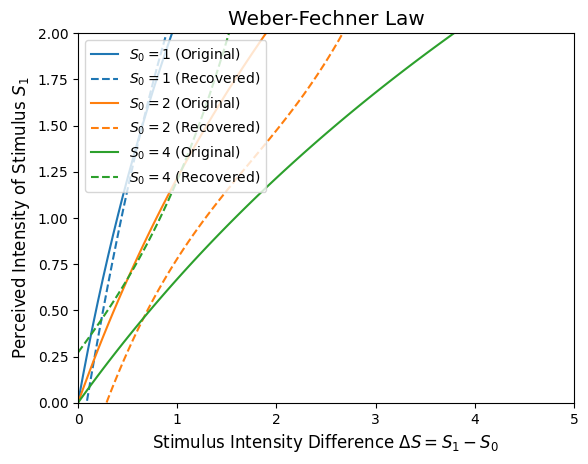

In [ ]:
present_results(model=poly_model, x_test=conditions_test, y_test=observations_test)

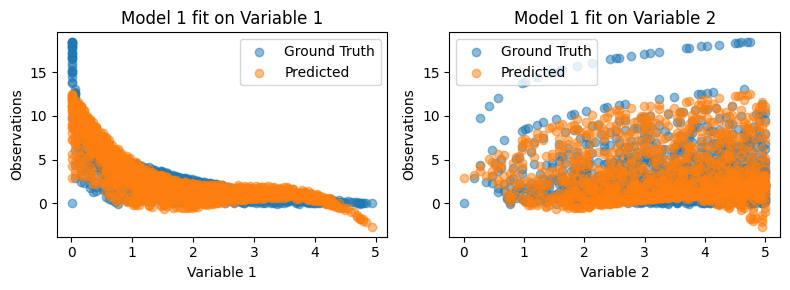

In [ ]:
present_results(model=poly_model, x_test=conditions_test, y_test=observations_test, arg='2d')

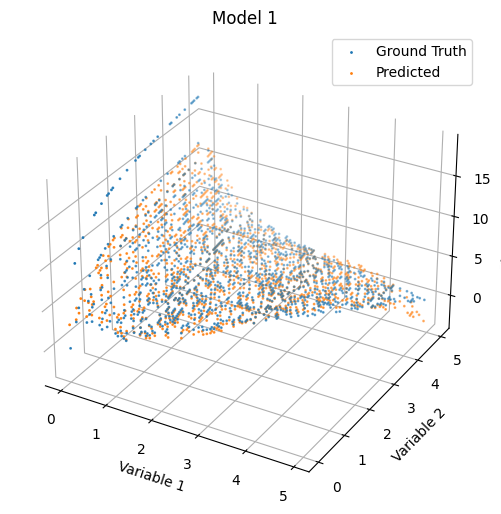

In [ ]:
present_results(model=poly_model, x_test=conditions_test, y_test=observations_test, arg='3d')

#### Summary - Polynomial Linear Regressor

Expressivity: Low

Interpretability: High

### Neural Network Regressor

####4. Initialize Regressor

In [ ]:
nn_model = MLPRegressor(random_state=1, max_iter=500)

####5. Fit Regressor

In [ ]:
nn_model.fit(conditions_train, observations_train)

MLPRegressor(max_iter=500, random_state=1)

####6. Evaluate Regressor

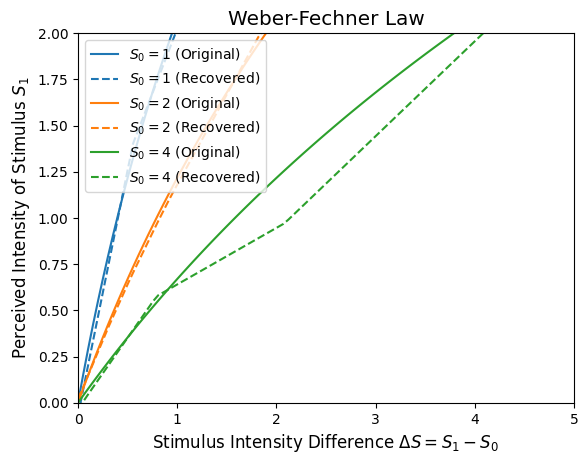

In [ ]:
synthetic_data.plotter(nn_model)

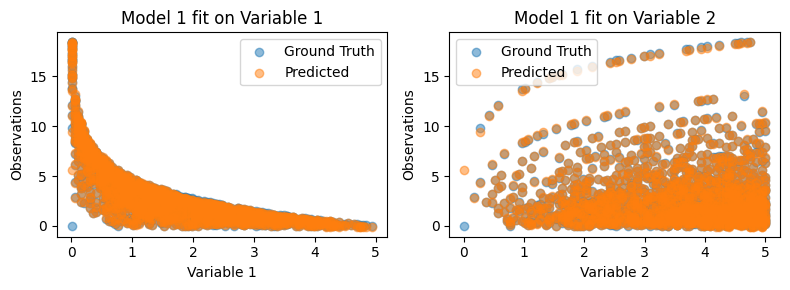

In [ ]:
present_results(model=nn_model, x_test=conditions_test, y_test=observations_test, arg='2d')

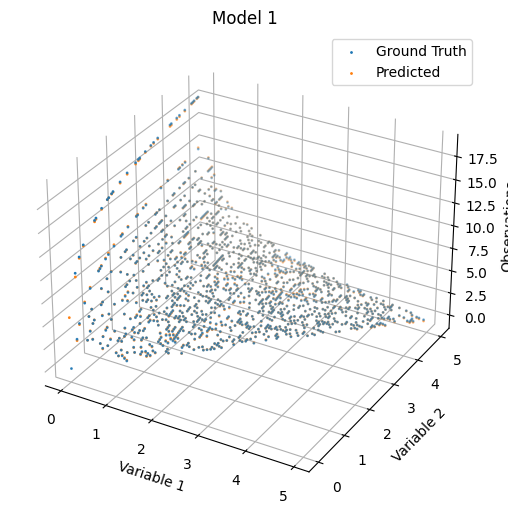

In [ ]:
present_results(model=nn_model, x_test=conditions_test, y_test=observations_test, arg='3d')

#### Summary - Neural Network Regressor

Expressivity: High

Interpretability: Low

### Bayesian Machine Scientist

####4. Initialize Regressor

In [ ]:
bms_model = BMSRegressor(epochs=1500)

####5. Fit Regressor

In [ ]:
bms_model.fit(conditions_train, observations_train)

100%|██████████| 1500/1500 [06:22<00:00,  3.92it/s]


log(((X0 / X1) ** -3.0))

####6. Evaluate Regressor

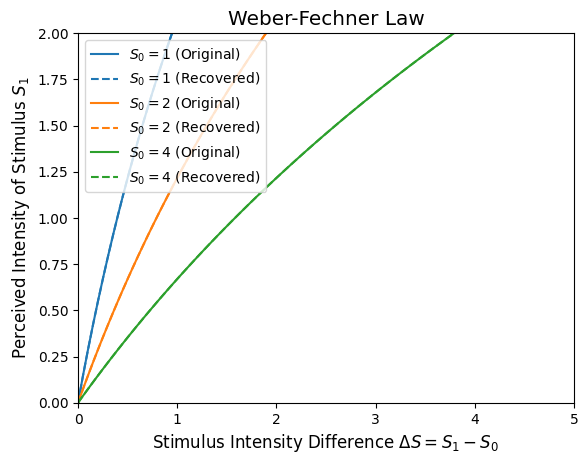

In [ ]:
synthetic_data.plotter(bms_model)

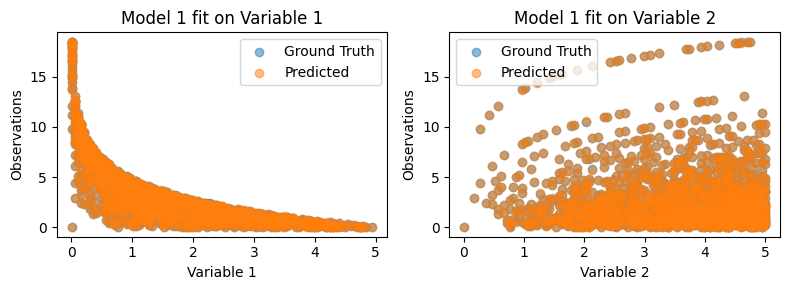

In [ ]:
present_results(model=bms_model, x_test=conditions_test, y_test=observations_test, arg='2d')

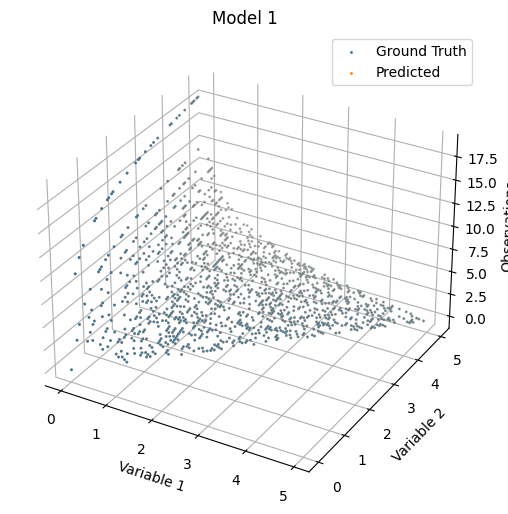

In [ ]:
present_results(model=bms_model, x_test=conditions_test, y_test=observations_test, arg='3d')

Here we see BMS successfully recovers the exact ground-truth equation

In [ ]:
print(bms_model)

log(((X0 / X1) ** -3.0))


#### Summary - BMS Regressor

Expressiveness: High

Interpretability: High

### Summary - Model Comparison

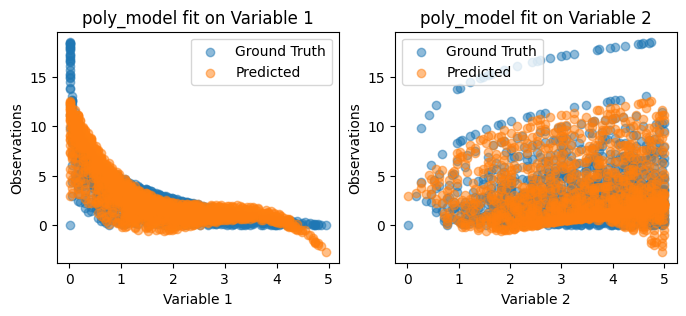

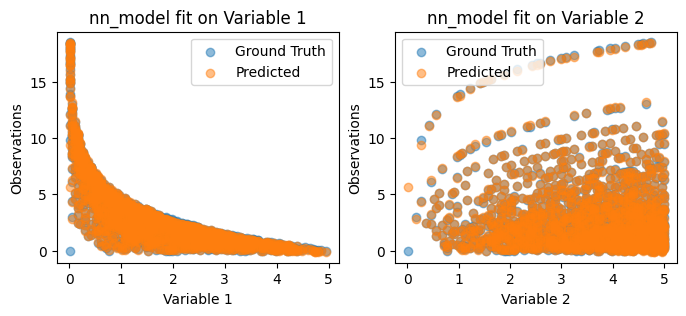

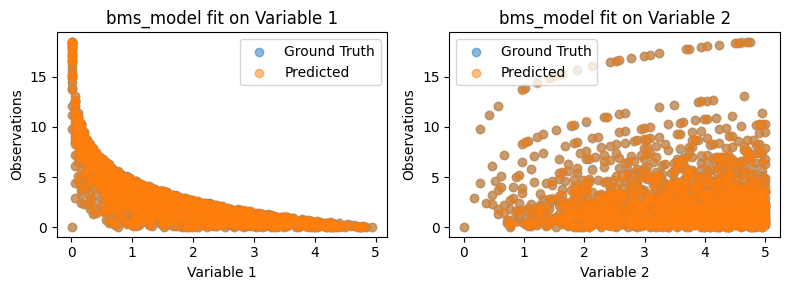

In [ ]:
models = [poly_model, nn_model, bms_model]
names =['poly_model', 'nn_model', 'bms_model']
compare_results(models=models, x_test=conditions_test, y_test=observations_test, model_names=names, arg='2d')

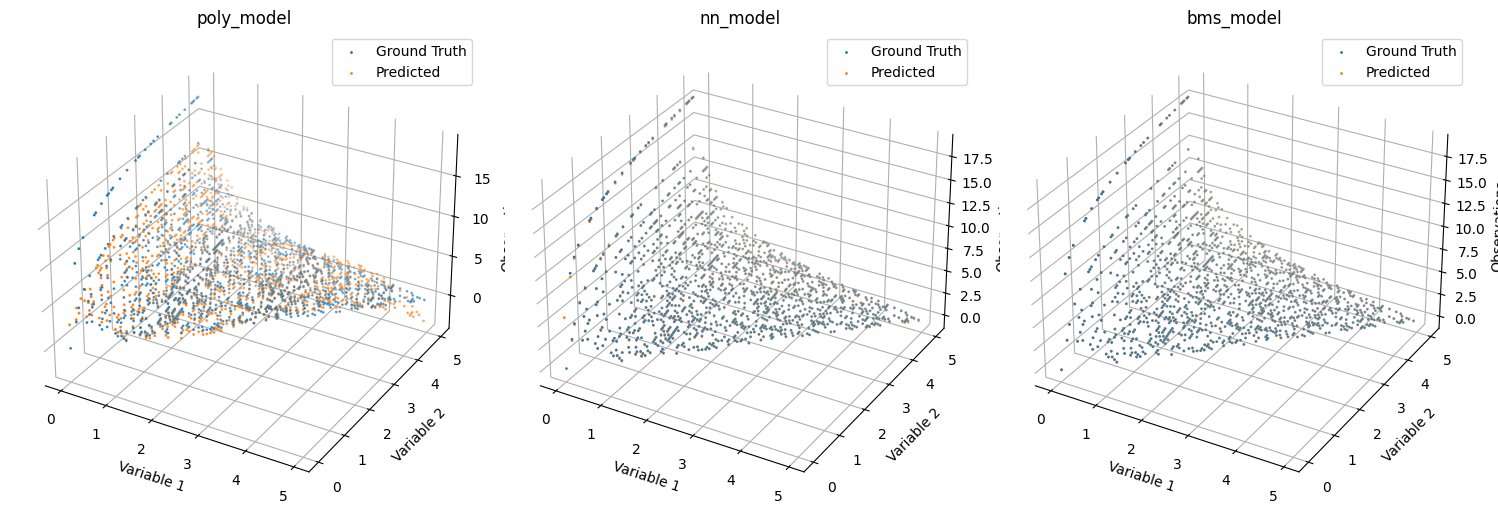

In [ ]:
compare_results(models=models, x_test=conditions_test, y_test=observations_test, model_names=names, arg='3d')

## Section C: Choice Model Recovery

###1. Install Packages

In [ ]:
# Uncomment the following line when running on Google Colab
# !pip install "autora[theorist-bms]"

###2. Import Packages

In [ ]:
from autora.experiment_runner.synthetic.psychology.luce_choice_ratio import luce_choice_ratio
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

###3. Load Data

We generate synthetic data from AutoRA's inventory of synthetic models

Here, we generate a synthetic example of Shepard's Luce Choice Ratio

In [ ]:
# experimental parameter to recover
focus = 0.8

# synthetic experiment from autora inventory
synthetic_data = luce_choice_ratio(focus=focus, added_noise=0.01)

# experimental data
conditions = synthetic_data.domain()
observations = synthetic_data.experiment_runner(conditions)

# set probabilities to choice values
observations = np.where(observations < 0.5, 0, 1)

# split into train and test datasets
conditions_train, conditions_test, observations_train, observations_test = train_test_split(conditions, observations)

###Model Recovery

We will use three models:
1. Logistic Regressor
2. Neural Network Classifier
3. Bayesian Machine Scientist

### Logistic Regressor

####4. Initialize Regressor

In [ ]:
log_model = LogisticRegression()

####5. Fit Regressor

In [ ]:
log_model.fit(conditions_train, observations_train)

LogisticRegression()

####6. Evaluate Regressor

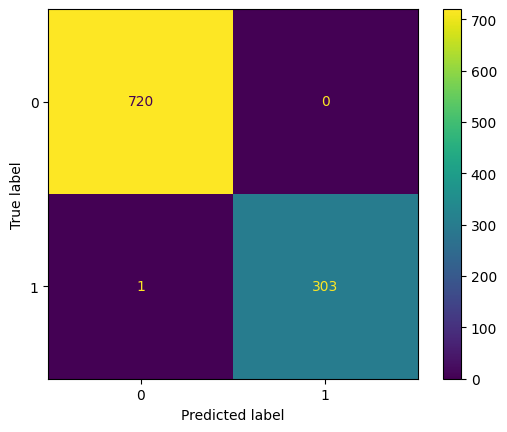

In [ ]:
present_results(model=log_model, x_test=conditions_test, y_test=observations_test, arg='choice')

#### Summary - Logisitic Regressor

Expressiveness: Low

Interpretability: High

###Neural Network Classifier

####4. Initialize Regressor

In [ ]:
nn_class_model = MLPClassifier(max_iter=3000, activation='logistic')

####5. Fit Regressor

In [ ]:
nn_class_model.fit(conditions_train, observations_train)

MLPClassifier(activation='logistic', max_iter=3000)

####6. Evaluate Regressor

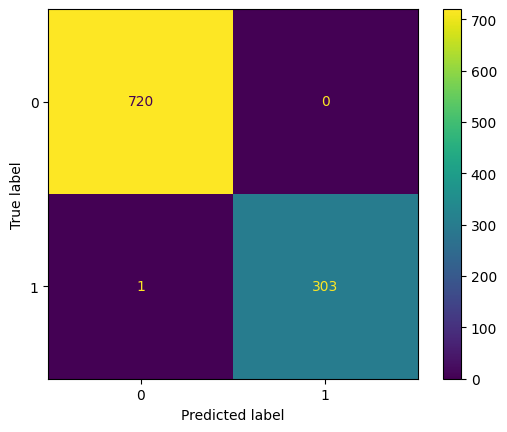

In [ ]:
present_results(model=nn_class_model, x_test=conditions_test, y_test=observations_test, arg='choice')

#### Summary - Neural Network Regressor

Expressiveness: High

Interpretability: Low

###Bayesian Machine Scientist

####4. Initialize Regressor

In [ ]:
bms_model = BMSRegressor(epochs=1500)

####5. Fit Regressor

In [ ]:
bms_model.fit(conditions_train, observations_train)

100%|██████████| 1500/1500 [08:18<00:00,  3.01it/s]


exp((-(((X1 / X0) ** X0)) * (1.24 ** ((X2 ** 1.24) + (X3 ** 1.24)))))

####6. Evaluate Regressor

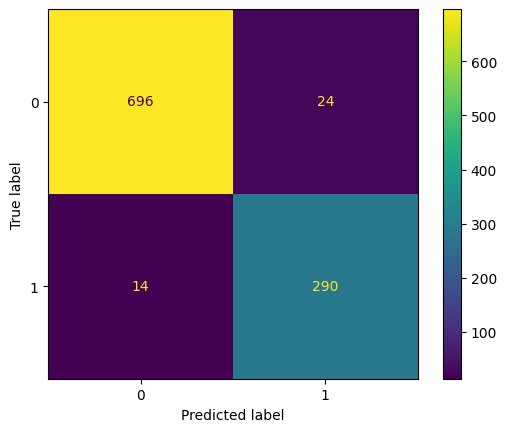

In [ ]:
present_results(model=bms_model, x_test=conditions_test, y_test=observations_test, arg='choice')

In [ ]:
print(bms_model)

exp((-(((X1 / X0) ** X0)) * (1.24 ** ((X2 ** 1.24) + (X3 ** 1.24)))))


#### Summary - BMS Regressor

Expressiveness: High

Interpretability: High

###Summary - Model Comparison

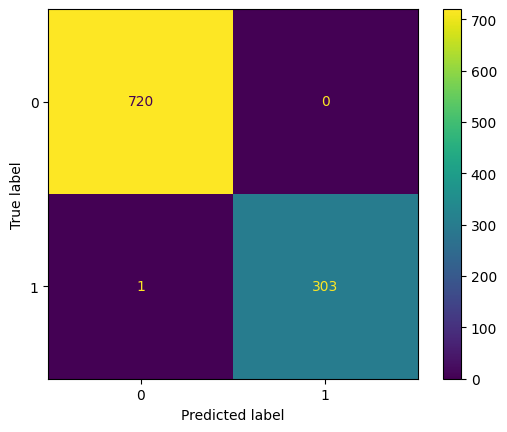

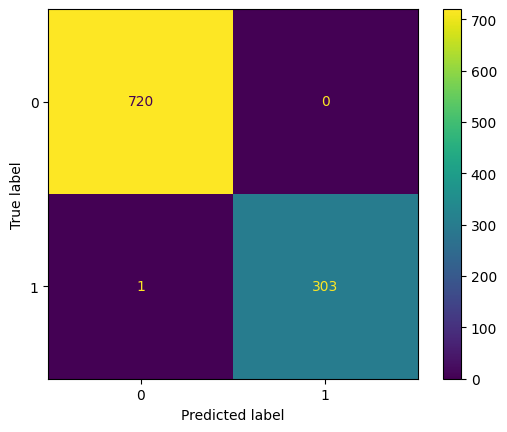

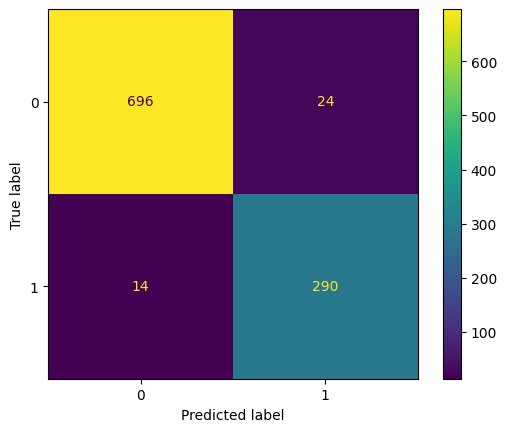

exp((-(((X1 / X0) ** X0)) * (1.24 ** ((X2 ** 1.24) + (X3 ** 1.24)))))


In [ ]:
models = [log_model, nn_class_model, bms_model]
names =['log_model', 'nn_class_model', 'bms_model']
compare_results(models=models, x_test=conditions_test, y_test=observations_test, model_names=names, arg='choice')
print(bms_model)